In [ ]:
!git clone -q -b upgrade-muse-inference https://github.com/marius311/muse-wl/
!pip install --upgrade "poetry==1.2.0b2"
!(cd muse-wl && POETRY_VIRTUALENVS_IN_PROJECT=true poetry install)
import sys, os.path as osp
sys.path = [osp.abspath("muse-wl/.venv/lib/python3.7/site-packages")] + sys.path

In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight', 'dpi': 90}

In [4]:
import jax
import jax.numpy as jnp
import muse_inference
from muse_inference.jax import JittableJaxMuseProblem, JaxMuseProblem
from muse_inference import MuseResult
import jax_cosmo as jc

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

import powerbox_jax as pbj
import haiku as hk
master_seed = hk.PRNGSequence(42)

/content/muse-wl/.venv/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/content/muse-wl/.venv/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


Check using expected device:

In [5]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


# Defining a model

In [6]:
def model(N=32,                # number of pixels on the map
          map_size=10,         # map size in deg.
          gal_per_arcmin2=30,   
          sigma_e=0.2):      
    
    pix_area = (map_size * 60 / N)**2 # arcmin2 
    map_size = map_size / 180 * pi    # radians

    
    # Sampling cosmology
    omega_c = numpyro.sample('omega_c', dist.Normal(0.3, 0.05))
    sigma_8 = numpyro.sample('sigma_8', dist.Normal(0.8, 0.05))
    
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma_8)
    # Creating a given redshift distribution
    pz = jc.redshift.smail_nz(0.5, 2., 1.0)
    tracer = jc.probes.WeakLensing([pz])
    
    # Defining the function that will compute the power spectrum of the field
    # Create an interpolation array for the cls to avoid far too many computations
    ell_tab = jnp.logspace(0, 4.5, 128)
    cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer], nonlinear_fn=jc.power.linear)[0]
    # Warning!!!!: I was too lazy to figure out the proper conversion from k to ell 
    P = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)
    
    pb = pbj.PowerBox(
        N=N,                                   # Number of grid-points in the box
        dim=2,                                 # 2D box
        pk = P,                                # The power-spectrum
        boxlength = map_size,                  # Size of the box (sets the units of k in pk)
        vol_normalised_power=True,             # normalise power by volume
        supplied_freqs=None
    )
      
    # Sampling field
    field = pb.delta_x()
    
    # Adding "observational noise"
    x = numpyro.sample('x', dist.Independent(dist.Normal(field, sigma_e/jnp.sqrt(gal_per_arcmin2 * pix_area)), 2))
    
    return x

In [7]:
# Create our fiducial observations
fiducial_model = condition(model, {'omega_c': 0.27, 'sigma_8': 0.77})
sample_map_fiducial = seed(fiducial_model, jax.random.PRNGKey(12345670))
m_data = sample_map_fiducial()

/content/muse-wl/.venv/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6690: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


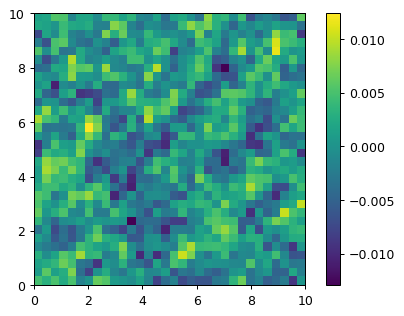

In [8]:
imshow(m_data, extent=(0,10,0,10))
colorbar()

In [9]:
@jax.jit
def log_likelihood(x, z, theta):
  oc = theta[0]
  s8 = theta[1]
  mag = z[0]
  pha = z[1]

  cond_model = condition(model, {'omega_c': oc, 'sigma_8': s8, 'x': x, 
                                 'gauss_hermitian_mag': mag, 
                                 'gauss_hermitian_pha': pha})
  model_trace = trace(cond_model).get_trace()

  return model_trace['x']['fn'].log_prob(model_trace['x']['value'])

@jax.jit
def log_prior(theta):
  oc = theta[0]
  s8 = theta[1]
  log_prob = dist.Normal(0.3, 0.05).log_prob(oc) + dist.Normal(0.8, 0.05).log_prob(s8) 
  return log_prob


@jax.jit 
def sample(theta, key):
  oc = theta[0]
  s8 = theta[1]
  cond_model = condition(seed(model, key), {'omega_c': oc, 'sigma_8': s8})
  model_trace = trace(cond_model).get_trace()
  return model_trace['x']['value'], (model_trace['gauss_hermitian_mag']['value'],
                                      model_trace['gauss_hermitian_pha']['value'])

In [10]:
class LensingProblem(JittableJaxMuseProblem):

    def sample_x_z(self, rng, θ):
        return sample(jnp.array(θ), rng)

    def logLike(self, x, z, θ):
        return log_likelihood(x, z, jnp.array(θ))

    def logPrior(self, θ):
        return log_prior(θ)

In [11]:
θ_true = 0.27, 0.77

In [12]:
prob = LensingProblem()
(x, z) = prob.sample_x_z(jax.random.PRNGKey(0), θ_true)
prob.x = x

/content/muse-wl/.venv/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6690: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


# Sanity check

Note: if I decrease to `z_tol=1e-2` or lower, I get a `history.status=4` which means saddle point?? Is this multi-modal? Or perhaps an issue with the phase being periodic?

In [13]:
MAP = prob.z_MAP_and_score(x, z, θ_true, z_tol=1e-1)

/content/muse-wl/.venv/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6690: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [14]:
MAP.history.success

DeviceArray(True, dtype=bool)

In [15]:
MAP.history.status

DeviceArray(0, dtype=int32, weak_type=True)

Text(0.5, 1.0, 'MAP phase')

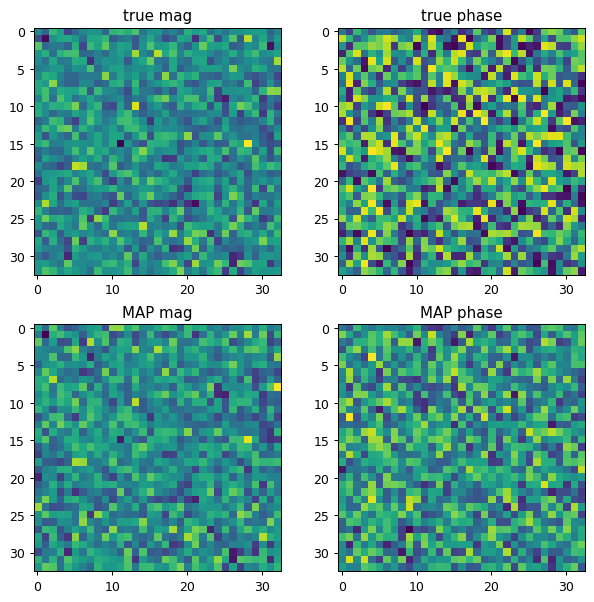

In [16]:
figure(figsize=(8,8))
subplot(221)
imshow(z[0])
title("true mag")
subplot(222)
imshow(z[1])
title("true phase")
subplot(223)
imshow(MAP.z[0])
title("MAP mag")
subplot(224)
imshow(MAP.z[1])
title("MAP phase")

# Get covariance

Compute the covariance evaluated at the truth, which involves getting the $J$ and $H$ matrices.

In [17]:
result = MuseResult()
result.θ = θ_true;

In [ ]:
prob.get_J(
    result, 
    nsims = 100, 
    progress = True, 
    z_tol = 1e-1, 
    rng = jax.random.PRNGKey(0)
);

get_J: 100%|██████████| 100/100 [02:56<00:00,  1.77s/it]


In [ ]:
prob.get_H(
    result, 
    θ = θ_true, 
    step = 0.1, 
    nsims = 10, 
    progress = True, 
    z_tol = 1e-1, 
    rng = jax.random.PRNGKey(0)
);

get_H: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


Looks like very little extra constraint beyond the prior, is that expected for this small map maybe?:

In [ ]:
sqrt(diag(result.Σ))

array([0.02660478, 0.04481153], dtype=float32)

Just to visualize the correlation:

Text(0, 0.5, '$\\sigma_8$')

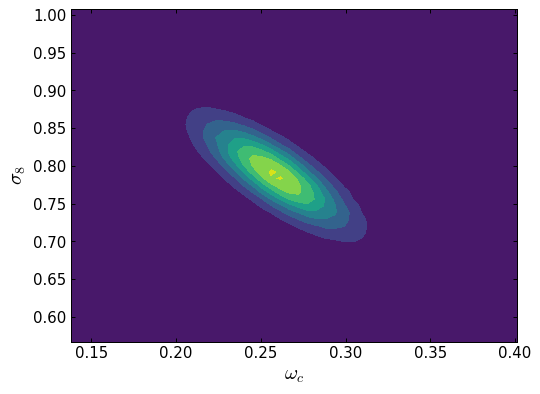

In [ ]:
Z, X, Y = histogram2d(*result.dist.rvs(1000000).T, bins=50, density=True)
contourf((X[1:]+X[:-1])/2, (Y[1:]+Y[:-1])/2, Z)
xlabel(r"$\omega_c$")
ylabel(r"$\sigma_8$")

# Get estimate

Run the estimate. Not really finding convergence yet.

In [ ]:
prob.solve(
    result = result, 
    α = 0.2, 
    θ_start = [0.3, 0.8], 
    θ_rtol = 0,
    z_tol = 1e-1, 
    progress = True, 
    maxsteps = 50, 
    nsims = 64,
    rng = jax.random.PRNGKey(1)
);

MUSE:   0%|          | 0/3250 [00:00<?, ?it/s]/global/u1/m/marius/work/muse-wl/.venv/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6623: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
MUSE:   2%|▏         | 65/3250 [01:54<1:05:18,  1.23s/it]/global/u1/m/marius/work/muse-wl/.venv/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6623: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#cu

The norm of the MUSE marginal score approximation, i.e. the thing we're trying to zero. This should hopefully descrease until it reaches zero within some tolerance.

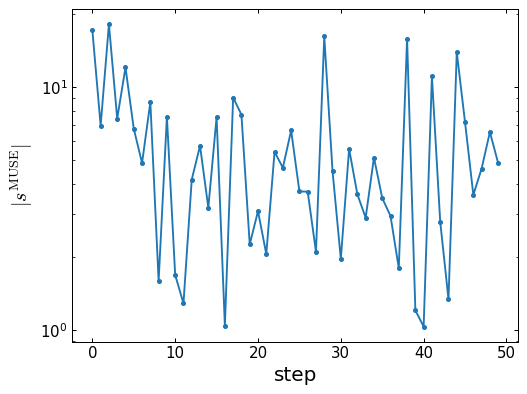

In [ ]:
plot([norm(h["s_post"]) for h in result.history],".-")
ylabel(r"$|s^{\rm MUSE}|$")
xlabel("step")
yscale("log")

Progression of $\theta$ across steps. Should see this converge to somewhere.


Text(0, 0.5, '$\\sigma_8$')

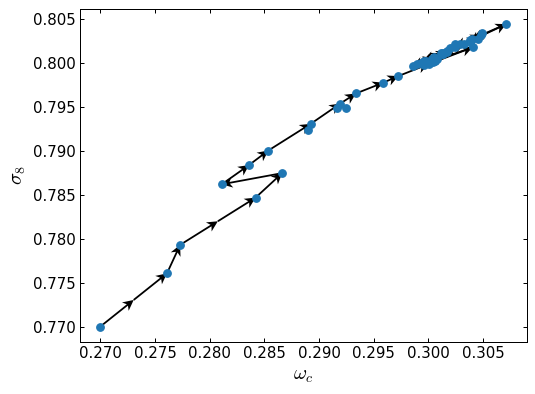

In [ ]:
# https://stackoverflow.com/a/66117937
x,y = transpose([h["θ"] for h in result.history])
plt.plot(x,y,"o")
ds = 0.003
Ns = np.round(np.sqrt( (x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2 ) / ds).astype(int)
subdiv = lambda x, Ns=Ns: np.concatenate([ np.linspace(x[ii], x[ii+1], Ns[ii]) for ii, _ in enumerate(x[:-1]) ])
x, y = subdiv(x), subdiv(y)
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, width=.004, headlength=6, headwidth=6)
xlabel(r"$\omega_c$")
ylabel(r"$\sigma_8$")